# 447 21fa exam 2 due 5p Fri Dec 10

***You are welcome (and encouraged) to:***
- use analytical and numerical computational tools -- specify the tool(s) in sourcecode and/or text;
- reuse example sourcecode and other materials provided in this course;
- consult textbooks, websites, and other publicly-available materials -- include full citation(s) with the URL and/or [DOI](https://en.wikipedia.org/wiki/Digital_object_identifier).

***You are not permitted to discuss the exam problems or share any part of your solutions with anyone other than the Professor or TA for this course.***
- By submitting your exam solution on Canvas, you are affirming your understanding of and adherence to these restrictions.
- We will answer questions during the class Zoom meetings Mon Dec 6 and Wed Dec 8.
- We will also answer questions posted to the Canvas Discussion board until 5p Fri Dec 10.

***The exam deadline is 5p Fri Dec 10 on Canvas.***
- Final submissions received before this deadline will receive +1 bonus points.
- Everyone automatically receives a deadline extension to 11:59p Sun Dec 12. ***No further deadline extensions will be granted -- please plan accordingly.***

# 0 -- set up environment

In [ ]:
# "magic" commands, prefaced with "%", changes settings in the notebook

# this ensures plots are embedded in notebook web page
%matplotlib inline

# pdb = Python debugger, so this command turns the debugger OFF
%pdb off

Automatic pdb calling has been turned OFF


## magic commands

## NumPy, SciPy, Matplotlib, SymPy

In [ ]:
# numpy = numerical Python, implements arrays (/ matrices)
import numpy as np
# limit number of decimal places printed for floating-point numbers
np.set_printoptions(precision=3)

# scipy = scientific Python, implements operations on arrays / matrices
import scipy as sp
# linalg = linear algebra, implements eigenvalues, matrix inverse, etc
from scipy import linalg as la
# optimize = optimization, root finding, etc
from scipy import optimize as op

# produce matlab-style plots
import matplotlib as mpl
# increase font size on plots
mpl.rc('font',**{'size':18})
# use LaTeX to render symbols
mpl.rc('text',usetex=False)
# render animation
mpl.rc('animation',html='html5')
# animation
from matplotlib import animation as ani
# Matlab-style plotting
import matplotlib.pyplot as plt

# symbolic computation, i.e. computer algebra (like Mathematica, Wolfram Alpha)
import sympy as sym


## OS and Colab/Jupyter 

In [ ]:
# os = operating system; access OS-level commands
# e.g. create directory, delete file, execute command
# (more platform-independent than "!")
import os

In [ ]:
# test whether this is a Colaboratory or Jupyter notebook
try:
  import google.colab
  COLAB = True
  print('Colaboratory Notebook')
except:
  COLAB = False
  print('Jupyter Notebook')

Colaboratory Notebook


In [ ]:
# Colab notebook
if COLAB:
  # pip = Python package manager; "!" means "run at system level"
  !pip install control
  !pip install JSAnimation
  
  # render SymPy equations nicely in Colaboratory Notebook
  def colab_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
    javascript(url=url)
    return sym.printing.latex(exp,**options)
  
  sym.init_printing(use_latex="mathjax",latex_printer=colab_latex_printer)

# Jupyter notebook
else:
  init_printing(use_latex='mathjax')
    

# Python's Control Systems Toolbox
import control as ctrl

# SciPy module that implements many of the routines in ctrl
from scipy import signal as sig

## helpful functions

In [ ]:
def Jacobian(g,y,d=1e-4):
  """
  approximate derivative via finite-central-differences 

  input:
    g - function - g : R^n -> R^m
    y - n array
    (optional)
    d - scalar - finite differences displacement parameter

  output:
    Dg(y) - m x n - approximation of Jacobian of g at y
  """
  # given $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
  # $$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
  e = np.identity(len(y))
  Dyg = []
  for j in range(len(y)):
      Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
  return np.array(Dyg).T

def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(x,u) 

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

# problem (1.)

Consider the following block diagram:

![block diagram](https://docs.google.com/drawings/d/e/2PACX-1vSrZYQ4nqWsHqgbqBAVMvo3TIwHwhmyB9VR-ve-vz36AkVQRV6v5PAREjXxqDURsiADKVTVprm7p2Y7/pub?w=321&h=138)

## subproblem (1a.)

If $A = P^{-1}$ and you are free to design $B$, is there a tradeoff between performance of reference-tracking and performance of disturbance-rejection?

### solution

We know that the block diagram defines the frequency-domain transformation $y = \frac{P(A+B)}{1 + P B} r + \frac{P}{1 + P B} d $.  If $A = P^{-1}$ then $G_{yr} = 1$, i.e. we achieve perfect reference tracking regardless of the choice of $B$, so there is no tradeoff between performance of reference-tracking and performance of disturbance-rejection.

Note that this finding is categorically different because of the inclusion of the "feedforward" block $A$ (and the specific choice $A = P^{-1}$ makes the conclusion particularly clear).  This type of control architecture is referred to as having "two degrees of freedom" since we can independently choose $A$ and $B$ to achieve different goals.


## subproblem (1b.)

Suppose the process transfer function $P$ has a zero in the right half-plane, that is, there exists $z\in\mathbb{C}$ such that $\operatorname{Re} z > 0$ and $P(z) = 0$.  

Explain why implementing $A = P^{-1}$ would be a bad idea.

### solution

If $P$ has a right-half-plane zero then $A = P^{-1}$ has a right-half-plane pole, so $A$ is unstable.  Although the math works out nicely in the frequency domain regardless of whether $A$ is stable ($G_{yr}$ still equals $1$), if we actually tried to implement subsystem $A$ then its internal state would "blow up", i.e. diverge to infinity.  In practical terms:
* if $A$ was implemented using analog elements, e.g. in a circuit or mechanism, the diverging state would literally destroy the circuit (or make the model invalid);
* if $A$ was implemented using a digital computer, e.g. in a microprocessor or CPU or GPU, the diverging state would cause arithmetic overflow errors.



# problem (2.)

Consider application of proportional feedback $C(s) = k_P$ in the standard negative feedback loop to the following process model:

$$ P(s) = \frac{s-1}{a(s)}. $$

## subproblem (2a.)

Suppose the closed-loop system can be stabilized by proportional feedback.  Explain why the controller gain $k_P$ cannot be too large.

### solution

In the limit as $k_P$ goes to $\infty$, one of the poles of the closed-loop transfer function converges to the zero of $P$ at $+1 \in \mathbb{C}$; since this point is in the right-half-plane, we conclude that sufficiently large proportional gains will destabilize the closed-loop system.



## subproblem (2b.)

Create the root-locus diagram for the closed-loop system when $a(s) = s^2 + s + 2$, and determine the upper bound on $k_P$ that ensures the closed-loop system is stable.

In [ ]:
!pip install control

     |████████████████████████████████| 339 kB 5.2 MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344928 sha256=e15edc24c13b6dd22ace2af6c6c697f32313b56965bba4b8af2cc013d97d3e9a
  Stored in directory: /root/.cache/pip/wheels/5b/64/54/70faad181d7baff1184541ca00c9a2efa633acd0a811831d30
Successfully built control


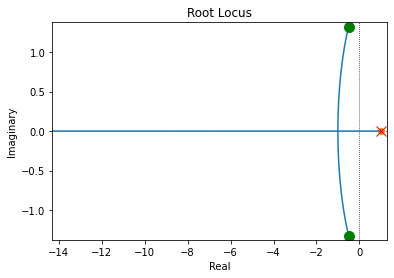

In [ ]:
import control as ctrl
import numpy as np
import pylab as plt

num = [1,-1]
den = [1,1,2]

tf = ctrl.tf(num,den)

r,g = ctrl.root_locus(tf,grid=False)

plt.plot(r[0].real,r[0].imag,'go',ms=10)
plt.plot(r[-1].real,r[-1].imag,'rx',ms=10)

To determine the maximum gain, we can check the list of gains returned from `ctrl.root_locus` to get a rough idea:

In [ ]:
g[(np.max(r.real,axis=1) < 0).nonzero()[0][-1]]

1.9401360544217685

In [ ]:
g[(np.max(r.real,axis=1) < 0).nonzero()[0][-1]+1]

2.002721088435374

This tells us that the maximum gain is between $1.940$ and $2.003$ -- to get a more precise value, we can compute the gain margin:

In [ ]:
gm,pm,sm,_,_,_ = ctrl.stability_margins(tf)

It turns out the gain margin is pretty much exactly $2$:

In [ ]:
gm

2.0

This also would have been easy to determine from the Nyquist plot:

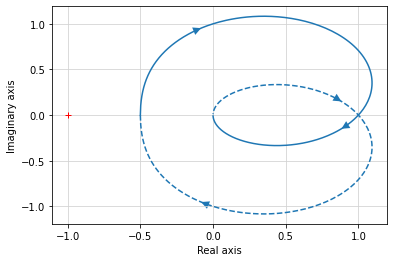

In [ ]:
ctrl.nyquist_plot(tf);


## subproblem (2c.)

Can you apply the Nyquist stability criterion from lecture to assess stability of the controlled system when $a(s) = s^2 - 1$?  Explain why or why not.

## solution

We cannot -- when $a(s) = s^2 - 1$, the (open-)loop transfer function is $L(s) = \frac{k_p (s-1)}{s^2 - 1}$, which has a pole in the right half-plane, so the Nyquist stability criterion from lecture is not applicable.

***Note:*** since one of the poles of L equals one of the zeros of L, it is tempting to "cancel" them and obtain the simplified expression for L:  $\frac{k_P}{s+1}$.  However, it is never a good idea in practice to rely on "pole/zero cancellations" -- if there is any modeling error (e.g. in the estimation of $P$ or implementation of $C$), the zero will not *exactly* cancel the pole, so we may erroneously conclude an unstable system is stable.  For instance, the un-simplified $L = \frac{k_p (s-1)}{s^2 - 1}$ *cannot* be stabilized with proportional feedback, whereas the simplified expression $\frac{k_P}{s+1}$ *can* be stabilized with proportional feedback (in fact, the closed-loop system is already stable with $k_P = 1$).

If we create the Nyquist diagram, we see that it does not encircle the "bad point" at $-1\in\mathbb{C}$, so we would erroneously conclude the system is stable if we applied the criterion from lecture.

0

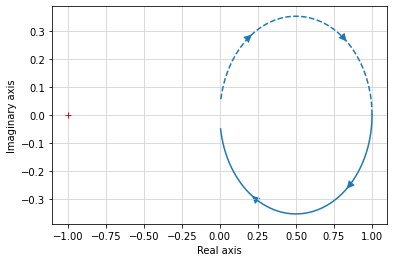

In [ ]:
num = [1,-1]
den = [2,0,-1]

tf = ctrl.tf(num,den)

ctrl.nyquist_plot(tf)



## subproblem (2d.)

Can the system be stabilized with proportional feedback when $a(s) = s^2 - 1$?

## solution

No -- this is clear from looking at the root locus diagram, as the right half-plane pole gets "pulled" to the right half-plane zero, so it remains unstable for all $k_P > 0$.

***Note*** the wrong conclusion is reached if the transfer function is simplified to $P(s) = \frac{k_P}{s+1}$ through "pole/zero cancellation".




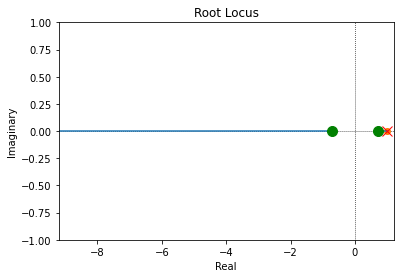

In [ ]:
r,g = ctrl.root_locus(tf,grid=False)

plt.plot(r[0].real,r[0].imag,'go',ms=10)
plt.plot(r[-1].real,r[-1].imag,'rx',ms=10)

# problem (3.)
Consider the following ***Bode plots*** of ***process*** $P(s)$ and ***controller*** $C(s)$ transfer functions -- note that applying the ***Nyquist stability criterion*** to the open-loop transfer function $L(s) = P(s) C(s)$ shows that the closed-loop system is stable.

![](http://faculty.washington.edu/sburden/447/447-19fa-bode-PC.png)

Suppose there is error in the measurement of the process model, so that the magnitude of the actual system's process transfer function could be off by as much as a factor of 10 (i.e. as small as $10\%$ or as large as $1,000\%$ of the value for $|P|$ graphed above).

How would you modify $C$ to ensure the closed-loop system is stable for any process transfer function within these error bounds?

## solution

The Nyquist plot crosses the negative real axis at $\omega_0 = 10^0 = 1$Hz -- since this crossing frequency is unaffected by changes in the magnitude of the process, the closed-loop system is stable if and only if $|\widetilde{P}(\omega_0 j)| \cdot |\widetilde{C}(\omega_0 j)| < 1$ where $\widetilde{P}$ is the perturbed process transfer function and $\widetilde{C}$ is the modified controller.  

If $|\widetilde{P}(\omega_0 j)| < |P(\omega_0 j)|$, we don't need to modify $|C(\omega_0 j)|$ to stabilize the closed-loop system.  

But if $|\widetilde{P}(\omega_0 j)| \approx 10 |P(\omega_0 j)|$, we need to decrease the control gain to ensure the closed-loop system is stable -- since $|P(\omega_0 j)|$ is between $0.1$ and $1$, choosing $\widetilde{C} = C/10$ will ensure $|\widetilde{L}(\omega_0 j)| = |\widetilde{P}(\omega_0 j)| \cdot |\widetilde{C}(\omega_0 j)| < 1$.


# problem (4.)

You just started a new job as a ***Senior Control System Engineer*** at a startup company that is creating autonomous vehicles.  Your first task in this new role is to lead the design of the *cruise control* subsystem.

You decide to use the following first-order process model for the relationship between the vehicle's throttle $\tau$ and velocity $v$: 

$$\dot{v} = -\alpha v + \beta \tau,$$

where $\alpha > 0$ is the coefficient of aerodynamic drag and $\beta > 0$ is the transmission gear ratio.  Your controller can directly measure velocity $v$.

## subproblem (a.)

Design a controller that will make the velocity $v$ converge to a desired speed $r > 0$.

### solution

We'll consider two approaches based on the ideas from this course:
1. design a stabilizing PI controller;
2. design a two degree-of-freedom controller as in Problem (1.) above consisting of a *feedforward* element that ensures $v = r$ is an equilibrium and a *feedback* element that ensures this equilibrium is stable.

Both approaches have advantages and disadvantages we will discuss as we go.

#### solution 1 (PI)

We use a similar design methodology as Problem 2 from Homework 1 -- applying controller $ C(s) = k_P + k_I/s $ to process $P(s) = \beta/(s+\alpha)$ in the standard negative feedback loop yields closed-loop transfer function 

$$ G_{vr}(s) = \frac{k_P \beta s + k_I\beta}{s^2 + (\alpha+k_P\beta) s + k_I \beta}. $$

Since $\alpha,\beta > 0$, any $k_P, k_I > 0$ ensures the closed-loop system is stable (all roots of the characteristic polynomial $a(s) = s^2 + (\alpha+k_P\beta) s + k_I \beta$ have negative real part, by the Routh-Hurwitz stability criterion).  And since $G_{vr}(0) = \frac{k_I\beta}{k_I\beta} = 1$, the vehicle speed $v$ will asymptotically converge to the desired reference $r > 0$.

#### solution 2 (FB + FF)

Note that the process $P(s) = \beta/(s+\alpha)$ is already stable since $\alpha > 0$, so all that's really needed is to determine the "feedforward" throttle $\tau_{FF}(r)$ that makes $v = r$ an equilibrium.  Since the dynamics of $v$ are scalar and linear, we can simply solve the equation $-\alpha r + \beta \tau = 0$ to find $\tau_{FF}(r) = \frac{\alpha}{\beta} r$.

If we want to be able to tune the rate of convergence, we could additionally apply *feedback* proportional to the error, $\tau_{FB}(v,r) = -\frac{k_P}{\beta} (v - r)$.

The overall control input is $\tau(v,r) = \tau_{FB}(v,r) + \tau_{FF}(r) = -\frac{k_P}{\beta} (v - r) + \frac{\alpha}{\beta} r$, resulting in closed-loop dynamics 
$$ \dot{v} = -\alpha v + \beta \tau(v,r) = -\alpha v - k_P (v - r) + \alpha r = (\alpha + k_P) (r - v), $$
which is clearly a stable first-order system that converges to $v = r > 0$.  
This controller can be visualized using the block diagram from Problem 1 above with $A = \alpha/\beta$ and $B = -k_P$.




## subproblem (b.)

Implement your controller from (a.) with $\alpha, \beta = 1$, provide a plot showing the velocity $v$ converging to the desired speed $r$, and compute the gain and phase margins $g_m$, $\varphi_m$ for the controlled system.



### solution (PI)




### solution (FB + FF)




## subproblem (c.)

You learned from a meeting with the mechatronics team that your model for the vehicle was overly simplistic -- in particular, the torque applied by the transmission changes with speed,

$$\dot{v} = -\alpha v + \gamma(v) \tau,$$

where $\gamma:\mathbb{R}\rightarrow\mathbb{R}$ is a smooth positive function that the mechatronics team can determine from their computer-aided design (CAD) program.  Explain how you would redesign your controller for a given $\gamma$.  Can you still ensure the velocity $v$ will converge to a desired speed $r > 0$?

### solution (PI)

Note that the term $\gamma(v) \tau$ is non-linear -- to apply linear control system analysis and synthesis techniques, we first need to linearize.

The first step in linearization is determining the operating point or equilibrium:  solving the non-linear equation $-\alpha r + \gamma(r) \tau = 0$ for $\tau$ yields input $\tau_0(r) = \frac{\alpha}{\gamma(r)} r$ that makes $v_0 = r$ an equilibrium.  

Differentiating $f(v,\tau) = -\alpha v + \gamma(v)\tau$ yields

$$ \partial_v f(v,\tau) = -\alpha + D\gamma(v) \tau,\ \partial_\tau f(v,\tau) = \gamma(v). $$

Evaluating the equilibrium $(v_0,\tau_0(r))$ yields

$$ A = \partial_v f(v_0,\tau_0) = -\alpha + D\gamma(r)\frac{\alpha}{\gamma(r)},\ B = \partial_\tau f(v_0,\tau_0) = \gamma(r). $$

Now we can apply PI control to the linearized process

$$ \dot{\delta v} = A \delta v + B \delta \tau $$

where $v \approx v_0 + \delta v$ when $\tau = \tau_0 + \delta \tau$.

Note that $A$ and $B$ above depend implicitly on $r$, so in practice we'd need to re-linearize and re-derive the controller for every desired speed $r$ (or verify that the controller synthesized for one value of $r$ yields acceptable performance when applied with another value for $r$).

### solution (FB + FF)

The solution is simpler in this case, because the 'equilibrium' throttle $\tau_0(r) = -\frac{\alpha}{\gamma(r)} r$ computed in the preceding PI solution can be directly employed as the 'feedforward' throttle $\tau_{FF}(r) = \frac{\alpha}{\gamma(r)} r$ to yield closed-loop dynamics

$$ \dot{v} = -\alpha v + \gamma(r) \tau_{FF}(r) = \alpha\cdot(r-v), $$

which is clearly a stable first-order system that converges to $v = r > 0$.

If we want to influence the convergence rate, we can apply the non-linear 'feedback' $\tau_{FB}(v,r) = -\frac{k_P}{\gamma(r)} (v - r)$ to obtain the same closed-loop dynamics as in the linear case:

$$ \dot{v} = -\alpha v + \gamma(r) (\tau_{FB}(v,r) + \tau_{FF}(r)) = (\alpha+k_P)(r-v). $$
